In [1]:
import json
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from sklearn.feature_extraction.text import CountVectorizer as countvec
from sklearn.cluster import KMeans as km
from sklearn.cluster import AgglomerativeClustering as hi
import scipy.cluster.hierarchy as hierarchy
from sklearn import mixture
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics.pairwise import pairwise_distances as pairdist
from sklearn import preprocessing
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# get longitude and latitude of each business_id, also with its categories
business = []
for row in open('business.json'):
    row = json.loads(row)
    if 'Restaurants' in row['categories'] and row['city'] == 'Las Vegas' and 'Alcohol' in row['attributes'] and 'NoiseLevel' in row['attributes'] and 'WiFi' in row['attributes']:
        business.append({'business_id':row['business_id'], 'longitude':row['longitude'],'latitude':row['latitude'],
                        'categories':row['categories'],'stars':row['stars'],'review_count':row['review_count'],
                        'neighborhood':row['neighborhood'],'NoiseLevel':row['attributes']['NoiseLevel'],
                         'Alcohol':row['attributes']['Alcohol'],'WiFi':row['attributes']['WiFi']})
        
business = DF(business)
business.head(5)

,Alcohol,NoiseLevel,WiFi,business_id,categories,latitude,longitude,neighborhood,review_count,stars
0,full_bar,average,free,Pd52CjgyEU3Rb8co6QfTPw,"[Nightlife, Bars, Barbeque, Sports Bars, Ameri...",36.066914,-115.170848,Southeast,13,4.0
1,full_bar,very_loud,free,n7V4cD-KqqE3OXk0irJTyA,"[Arcades, Arts & Entertainment, Gastropubs, Re...",36.068259,-115.178877,Southeast,349,3.0
2,none,very_loud,free,Wpt0sFHcPtV5MO9He7yMKQ,"[Restaurants, Fast Food, Burgers]",36.130013,-115.109310,Eastside,20,2.0
3,beer_and_wine,average,free,W1Yr6c2XDx_RBjb6WsV-aQ,"[Restaurants, Cafes, American (New), Bars, Nig...",36.170706,-115.190288,Westside,140,4.0
4,none,average,no,vzx1WdVivFsaN4QYrez2rw,"[Sandwiches, Restaurants, Fast Food]",36.112895,-115.062353,,3,3.0


In [3]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 10 columns):
Alcohol         4172 non-null object
NoiseLevel      4172 non-null object
WiFi            4172 non-null object
business_id     4172 non-null object
categories      4172 non-null object
latitude        4172 non-null float64
longitude       4172 non-null float64
neighborhood    4172 non-null object
review_count    4172 non-null int64
stars           4172 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 326.0+ KB


In [4]:
biz = business.drop('stars',axis=1)
biz.head()

,Alcohol,NoiseLevel,WiFi,business_id,categories,latitude,longitude,neighborhood,review_count
0,full_bar,average,free,Pd52CjgyEU3Rb8co6QfTPw,"[Nightlife, Bars, Barbeque, Sports Bars, Ameri...",36.066914,-115.170848,Southeast,13
1,full_bar,very_loud,free,n7V4cD-KqqE3OXk0irJTyA,"[Arcades, Arts & Entertainment, Gastropubs, Re...",36.068259,-115.178877,Southeast,349
2,none,very_loud,free,Wpt0sFHcPtV5MO9He7yMKQ,"[Restaurants, Fast Food, Burgers]",36.130013,-115.109310,Eastside,20
3,beer_and_wine,average,free,W1Yr6c2XDx_RBjb6WsV-aQ,"[Restaurants, Cafes, American (New), Bars, Nig...",36.170706,-115.190288,Westside,140
4,none,average,no,vzx1WdVivFsaN4QYrez2rw,"[Sandwiches, Restaurants, Fast Food]",36.112895,-115.062353,,3


In [5]:
lati=business['latitude'].values
longi=business['longitude'].values

In [6]:
# load review json file
review = []
for r in open('review.json'):
    line = json.loads(r)
    review.append({'business_id':line['business_id'], 'text':line['text'], 'date':line['date'], 
                   'stars':line['stars'], 'review_id':line['review_id']})
review = DF(review)

In [7]:
review.head()

,business_id,date,review_id,stars,text
0,0W4lkclzZThpx3V65bVgig,2016-05-28,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place...."
1,AEx2SYEUJmTxVVB18LlCwA,2016-05-28,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...
2,VR6GpWIda3SfvPC-lg9H3w,2016-05-28,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...
3,CKC0-MOWMqoeWf6s-szl8g,2016-05-28,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...
4,ACFtxLv8pGrrxMm6EgjreA,2016-05-28,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...


In [8]:
# concatenate reviews with the business_id
data_tmp = pd.merge(review,biz)
data_tmp.head(5)

,business_id,date,review_id,stars,text,Alcohol,NoiseLevel,WiFi,categories,latitude,longitude,neighborhood,review_count
0,9Jc3W0aR9Xf2gcHI0rEXsw,2012-08-23,QgSf2JvYz-M4PU2yuJjxNQ,1,"After being scared away from Rock & Rita's, we...",full_bar,average,no,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
1,9Jc3W0aR9Xf2gcHI0rEXsw,2013-07-09,Pj41wBNrL1TPM0aKwqGNgQ,2,Came here for dinner b/c we arrived at the hot...,full_bar,average,no,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
2,9Jc3W0aR9Xf2gcHI0rEXsw,2013-07-08,D7YruuihDlR2ASh1vvankw,2,There is no more prime rib. According to the w...,full_bar,average,no,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
3,9Jc3W0aR9Xf2gcHI0rEXsw,2008-11-24,s8j02t2pcqtGzZTwRwYsHA,5,The Garden Grill is located inside the Circus ...,full_bar,average,no,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
4,9Jc3W0aR9Xf2gcHI0rEXsw,2013-02-09,qC6VnDrkxOLEP4hyvtiwqg,4,All you can eat Prime Rib was DELICIOUS!!!!!! ...,full_bar,average,no,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57


In [9]:
data_tmp['year'], data_tmp['rest'] = data_tmp['date'].str.split('-', 1).str

In [10]:
data_tmp['month'], data_tmp['new_date'] = data_tmp['rest'].str.split('-', 1).str

In [11]:
data_tmp.drop('rest', axis=1, inplace=True)

In [12]:
data_tmp.head(500)
len(data_tmp)

879896

In [13]:
rc = data_tmp['review_count'] > 4000
new_data_tmp = data_tmp[rc]
new_data_tmp.head()

,business_id,date,review_id,stars,text,Alcohol,NoiseLevel,WiFi,categories,latitude,longitude,neighborhood,review_count,year,month,new_date
33793,f4x1YBxkLrZg652xt2KR5g,2016-06-22,sqX-4E1wsfW9CE6-RFwKmw,4,"I'd been to the Hash House downtown, but not t...",full_bar,average,no,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2016,06,22
33794,f4x1YBxkLrZg652xt2KR5g,2017-07-12,sD0KL4CwBVceyO0Nc8Y6Yw,4,The portions are huge the food is delicious. M...,full_bar,average,no,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2017,07,12
33795,f4x1YBxkLrZg652xt2KR5g,2014-03-13,gwF_GdU-AvWZp1Bbynmhgw,2,"Overrated! Went here for brunch, told 30 minu...",full_bar,average,no,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2014,03,13
33796,f4x1YBxkLrZg652xt2KR5g,2012-10-29,AMo5Nk8GAgm0OhQrnNm01A,4,"I have been to all the HHGGs in town, and fina...",full_bar,average,no,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2012,10,29
33797,f4x1YBxkLrZg652xt2KR5g,2011-12-30,DNivSyKQ8OmYwCQWwmUQJw,5,"Holy cow. Where do I start?\nFirst of all, I h...",full_bar,average,no,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2011,12,30


In [14]:
newdata = new_data_tmp.drop('review_id', axis=1)
newdata = newdata.drop('text', axis=1)
newdata = newdata.drop('latitude', axis=1)
newdata = newdata.drop('longitude', axis=1)
newdata = newdata.drop('neighborhood', axis=1)
newdata = newdata.drop('categories', axis=1)
# newdata.sort_values(by='year')
# newdata.index = newdata['date']
newdata.sort_values(by='date',inplace=True)
# n = newdata.head(100)
newdata.head()

,business_id,date,stars,Alcohol,NoiseLevel,WiFi,review_count,year,month,new_date
166640,4JNXUYY8wbaaDmk3BPzlWw,2005-10-10,5,full_bar,average,no,7361,2005,10,10
168967,4JNXUYY8wbaaDmk3BPzlWw,2005-10-15,5,full_bar,average,no,7361,2005,10,15
164850,4JNXUYY8wbaaDmk3BPzlWw,2005-12-02,4,full_bar,average,no,7361,2005,12,02
168181,4JNXUYY8wbaaDmk3BPzlWw,2006-01-07,4,full_bar,average,no,7361,2006,01,07
165026,4JNXUYY8wbaaDmk3BPzlWw,2006-01-31,5,full_bar,average,no,7361,2006,01,31


In [15]:
newdata2 = data_tmp.drop('review_id', axis=1)
newdata2 = newdata2.drop('text', axis=1)
newdata2 = newdata2.drop('latitude', axis=1)
newdata2 = newdata2.drop('longitude', axis=1)
newdata2 = newdata2.drop('neighborhood', axis=1)
newdata2 = newdata2.drop('categories', axis=1)
newdata2.sort_values(by='date',inplace=True)
newdata2.head()

,business_id,date,stars,Alcohol,NoiseLevel,WiFi,review_count,year,month,new_date
141938,ZkGDCVKSdf8m76cnnalL-A,2005-01-26,4,beer_and_wine,average,no,2108,2005,01,26
140948,ZkGDCVKSdf8m76cnnalL-A,2005-01-26,5,beer_and_wine,average,no,2108,2005,01,26
671455,MqYYYNA-ZYvV-1w5qcmMoA,2005-03-09,5,full_bar,average,no,650,2005,03,09
86373,Cr4ipI-tr-R8Q0NilkWNkA,2005-04-13,5,full_bar,average,no,951,2005,04,13
607377,ZpMoI5EECS6Rm7KigN1gPg,2005-04-15,3,full_bar,average,free,328,2005,04,15


In [16]:
newdata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879896 entries, 141938 to 752384
Data columns (total 10 columns):
business_id     879896 non-null object
date            879896 non-null object
stars           879896 non-null int64
Alcohol         879896 non-null object
NoiseLevel      879896 non-null object
WiFi            879896 non-null object
review_count    879896 non-null int64
year            879896 non-null object
month           879896 non-null object
new_date        879896 non-null object
dtypes: int64(2), object(8)
memory usage: 73.8+ MB


In [17]:
newdata.head()

,business_id,date,stars,Alcohol,NoiseLevel,WiFi,review_count,year,month,new_date
166640,4JNXUYY8wbaaDmk3BPzlWw,2005-10-10,5,full_bar,average,no,7361,2005,10,10
168967,4JNXUYY8wbaaDmk3BPzlWw,2005-10-15,5,full_bar,average,no,7361,2005,10,15
164850,4JNXUYY8wbaaDmk3BPzlWw,2005-12-02,4,full_bar,average,no,7361,2005,12,02
168181,4JNXUYY8wbaaDmk3BPzlWw,2006-01-07,4,full_bar,average,no,7361,2006,01,07
165026,4JNXUYY8wbaaDmk3BPzlWw,2006-01-31,5,full_bar,average,no,7361,2006,01,31


In [18]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39429 entries, 166640 to 136959
Data columns (total 10 columns):
business_id     39429 non-null object
date            39429 non-null object
stars           39429 non-null int64
Alcohol         39429 non-null object
NoiseLevel      39429 non-null object
WiFi            39429 non-null object
review_count    39429 non-null int64
year            39429 non-null object
month           39429 non-null object
new_date        39429 non-null object
dtypes: int64(2), object(8)
memory usage: 3.3+ MB


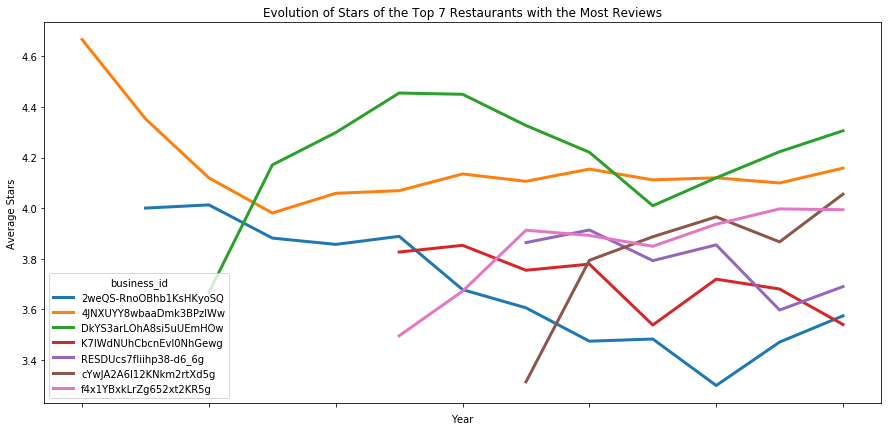

In [19]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
newdata.groupby(['year','business_id']).mean()['stars'].unstack().plot(ax=ax,lw=3.0,ls='-')
plt.xlabel('Year')
plt.ylabel('Average Stars')
plt.title('Evolution of Stars of the Top 7 Restaurants with the Most Reviews')
plt.show()

In [20]:
n = newdata.groupby(['business_id','year'], as_index=False)['stars'].mean()
n.head()

,business_id,year,stars
0,2weQS-RnoOBhb1KsHKyoSQ,2006,4.000000
1,2weQS-RnoOBhb1KsHKyoSQ,2007,4.012658
2,2weQS-RnoOBhb1KsHKyoSQ,2008,3.881356
3,2weQS-RnoOBhb1KsHKyoSQ,2009,3.856397
4,2weQS-RnoOBhb1KsHKyoSQ,2010,3.888235


In [21]:
dx1=[]
dy1=[]
dx2=[]
dy2=[]
for x, y in n.groupby('business_id'):
    if x == 'K7lWdNUhCbcnEvI0NhGewg':
        dx1.append(y['year'])
        dy1.append(y['stars'])
    elif x == 'f4x1YBxkLrZg652xt2KR5g':
        dx2.append(y['year'])
        dy2.append(y['stars'])
dx1 = dx1[0]
dy1 = dy1[0]
dx2 = dx2[0]
dy2 = dy2[0]

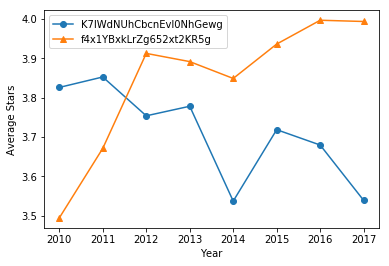

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(dx1, dy1, '-o', label='K7lWdNUhCbcnEvI0NhGewg')
ax.plot(dx2, dy2, '-^', label='f4x1YBxkLrZg652xt2KR5g')
plt.xlabel('Year')
plt.ylabel('Average Stars')
ax.legend()
plt.show()

In [23]:
y2 = dy2.values
y1 = dy1.values
distances = np.zeros((len(y2), len(y1)))
distances

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
for i in range(len(y2)):
    for j in range(len(y1)): 
        distances[i,j] = np.linalg.norm(y1[j]-y2[i])

In [25]:
distances

array([[0.33140611, 0.35797354, 0.25931276, 0.28362104, 0.04269726,
        0.22410856, 0.18509443, 0.04455966],
       [0.15473864, 0.18130607, 0.0826453 , 0.10695357, 0.1339702 ,
        0.04744109, 0.00842697, 0.13210781],
       [0.08644949, 0.05988206, 0.15854283, 0.13423456, 0.37515833,
        0.19374704, 0.23276116, 0.37329594],
       [0.0656007 , 0.03903327, 0.13769405, 0.11338577, 0.35430954,
        0.17289825, 0.21191238, 0.35244715],
       [0.02283391, 0.00373352, 0.09492725, 0.07061898, 0.31154275,
        0.13013146, 0.16914558, 0.30968036],
       [0.11015109, 0.08358366, 0.18224443, 0.15793616, 0.39885993,
        0.21744864, 0.25646276, 0.39699754],
       [0.17065217, 0.14408474, 0.24274552, 0.21843724, 0.45936102,
        0.27794972, 0.31696385, 0.45749862],
       [0.16748906, 0.14092163, 0.23958241, 0.21527413, 0.4561979 ,
        0.27478661, 0.31380074, 0.45433551]])

In [26]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("K7lWdNUhCbcnEvI0NhGewg")
    plt.ylabel("f4x1YBxkLrZg652xt2KR5g")
    plt.grid()
    plt.colorbar();

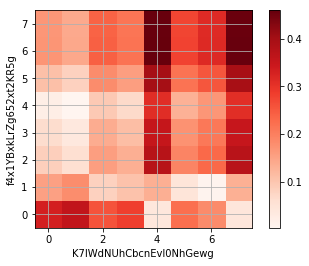

In [27]:
distance_cost_plot(distances)

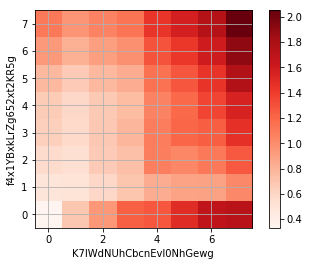

In [28]:
# Warping Path Calculations
accumulated_cost = np.zeros((len(y2), len(y1)))
accumulated_cost[0,0] = distances[0,0]
for i in range(1, len(y1)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1] 
for i in range(1, len(y2)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]  
# Accumulated Cost (D(i,j))=min{D(i−1,j−1),D(i−1,j),D(i,j−1)}+distance(i,j)
for i in range(1, len(y2)):
    for j in range(1, len(y1)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
distance_cost_plot(accumulated_cost)

In [29]:
# Backtracking and finding the optimal warp path
path = [[len(y1)-1, len(y2)-1]]
i = len(y2)-1
j = len(y1)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [30]:
print(path)

[[7, 7], [6, 6], [5, 5], [4, 4], [3, 4], [2, 4], [1, 3], [1, 2], [0, 1], [0, 0]]


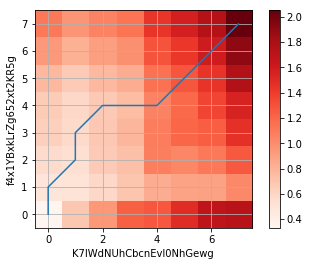

In [31]:
path_y1 = [point[0] for point in path]
path_y2 = [point[1] for point in path]
distance_cost_plot(accumulated_cost)
plt.plot(path_y1, path_y2);

In [32]:
n2 = newdata2.groupby(['Alcohol','month'], as_index=False)['stars'].mean()
n3 = newdata2.groupby(['NoiseLevel','month'], as_index=False)['stars'].mean()
n4 = newdata2.groupby(['WiFi','month'], as_index=False)['stars'].mean()

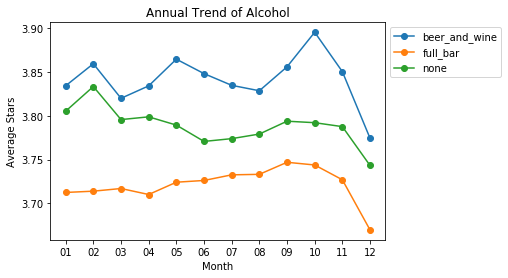

In [33]:
baw1=[]
baw2=[]
fb1=[]
fb2=[]
no1 = []
no2 = []
for x, y in n2.groupby('Alcohol'):
    if x == 'beer_and_wine':
        baw1.append(y['month'])
        baw2.append(y['stars'])
    elif x == 'full_bar':
        fb1.append(y['month'])
        fb2.append(y['stars'])
    else:
        no1.append(y['month'])
        no2.append(y['stars'])

baw1 = baw1[0]
baw2 = baw2[0]
fb1 = fb1[0]
fb2 = fb2[0]
no1 = no1[0]
no2 = no2[0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(baw1, baw2, '-o', label='beer_and_wine')
ax.plot(fb1, fb2, '-o', label='full_bar')
ax.plot(no1, no2, '-o', label='none')
plt.xlabel('Month')
plt.ylabel('Average Stars')
plt.title("Annual Trend of Alcohol")
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

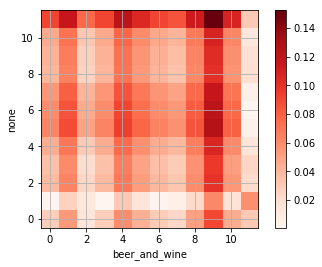

In [40]:
ynew2 = no2.values
ynew1 = baw2.values
distances1 = np.zeros((len(ynew2), len(ynew1)))

for i in range(len(ynew2)):
    for j in range(len(ynew1)): 
        distances1[i,j] = abs(ynew1[j]-ynew2[i])

def distance_cost_plot1(distances1):
    im = plt.imshow(distances1, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("beer_and_wine")
    plt.ylabel("none")
    plt.grid()
    plt.colorbar()
distance_cost_plot1(distances1)

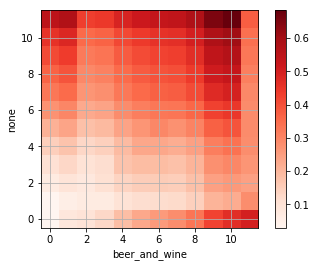

In [41]:
# Warping Path Calculations
accumulated_cost1 = np.zeros((len(ynew2), len(ynew1)))
accumulated_cost1[0,0] = distances1[0,0]
for i in range(1, len(ynew1)):
    accumulated_cost1[0,i] = distances1[0,i] + accumulated_cost1[0, i-1] 
for i in range(1, len(ynew2)):
    accumulated_cost1[i,0] = distances1[i, 0] + accumulated_cost1[i-1, 0]  
# Accumulated Cost (D(i,j))=min{D(i−1,j−1),D(i−1,j),D(i,j−1)}+distance(i,j)
for i in range(1,len(ynew2)):
    for j in range(1,len(ynew1)):
        accumulated_cost1[i, j] = min(accumulated_cost1[i-1, j-1], accumulated_cost1[i-1, j], accumulated_cost1[i, j-1]) + distances1[i, j]
distance_cost_plot1(accumulated_cost1)

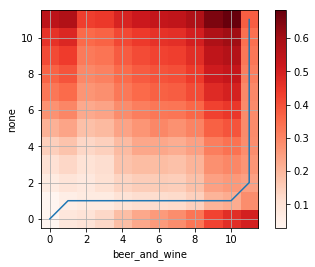

In [42]:
# Backtracking and finding the optimal warp path
path1 = [[len(ynew1)-1, len(ynew2)-1]]
i = len(ynew2)-1
j = len(ynew1)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost1[i-1, j] == min(accumulated_cost1[i-1, j-1], accumulated_cost1[i-1, j], accumulated_cost1[i, j-1]):
            i = i - 1
        elif accumulated_cost1[i, j-1] == min(accumulated_cost1[i-1, j-1], accumulated_cost1[i-1, j], accumulated_cost1[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path1.append([j, i])
path1.append([0,0])
path_y11 = [point[0] for point in path1]
path_y21 = [point[1] for point in path1]
distance_cost_plot1(accumulated_cost1)
plt.plot(path_y11, path_y21);

In [37]:
print(path1)

[[11, 11], [10, 10], [9, 9], [8, 8], [7, 7], [6, 6], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1], [0, 0], [0, 0]]


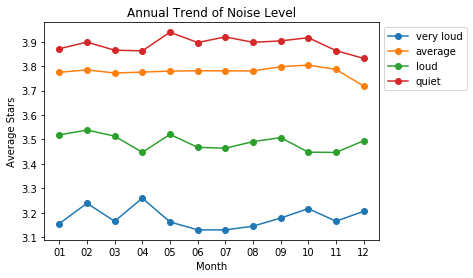

In [38]:
vl1=[]
vl2=[]
a1=[]
a2=[]
l1 = []
l2 = []
q1 = []
q2 = []
for x, y in n3.groupby('NoiseLevel'):
    if x == 'very_loud':
        vl1.append(y['month'])
        vl2.append(y['stars'])
    elif x == 'average':
        a1.append(y['month'])
        a2.append(y['stars'])
    elif x == 'loud':
        l1.append(y['month'])
        l2.append(y['stars'])
    else:
        q1.append(y['month'])
        q2.append(y['stars'])

vl1 = vl1[0]
vl2 = vl2[0]
a1 = a1[0]
a2 = a2[0]
l1 = l1[0]
l2 = l2[0]
q1 = q1[0]
q2 = q2[0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(vl1, vl2, '-o', label='very loud')
ax.plot(a1, a2, '-o', label='average')
ax.plot(l1, l2, '-o', label='loud')
ax.plot(q1, q2, '-o', label='quiet')
plt.xlabel('Month')
plt.ylabel('Average Stars')
plt.title("Annual Trend of Noise Level")
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

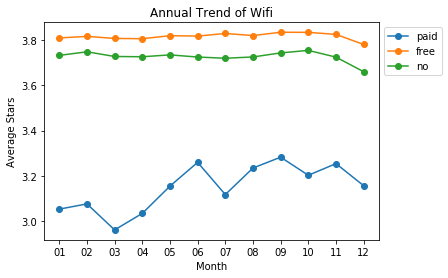

In [39]:
paid1=[]
paid2=[]
free1=[]
free2=[]
now1 = []
now2 = []
for x, y in n4.groupby('WiFi'):
    if x == 'paid':
        paid1.append(y['month'])
        paid2.append(y['stars'])
    elif x == 'free':
        free1.append(y['month'])
        free2.append(y['stars'])
    else:
        now1.append(y['month'])
        now2.append(y['stars'])

paid1 = paid1[0]
paid2 = paid2[0]
free1 = free1[0]
free2 = free2[0]
now1 = now1[0]
now2 = now2[0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(paid1, paid2, '-o', label='paid')
ax.plot(free1, free2, '-o', label='free')
ax.plot(now1, now2, '-o', label='no')
plt.xlabel('Month')
plt.ylabel('Average Stars')
plt.title("Annual Trend of Wifi")
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

In [49]:
month_ratings = newdata2.groupby(['month'], as_index=False)['stars'].mean()
month_ratings.head(12)

,month,stars
0,01,3.761286
1,02,3.774103
2,03,3.757516
3,04,3.757646
4,05,3.769111
5,06,3.763229
6,07,3.764191
7,08,3.764439
8,09,3.781175
9,10,3.787033


Text(0.5,0,'Month')

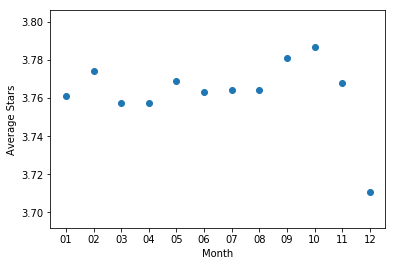

In [56]:
plt.scatter(month_ratings['month'], month_ratings['stars'])
plt.ylabel("Average Stars")
plt.xlabel("Month")